# Pix2Pix 

Following code Separately load and assign the weights each layer of generator network

## Import TensorFlow and other libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import os
os.environ['CUDA_VISIBLE_DEVICES']=''
import time

from matplotlib import pyplot as plt
from IPython import display
import numpy as np
from termcolor import colored

In [3]:
PATH = 'dataset/'
BUFFER_SIZE = 10
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [4]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return real_image,input_image

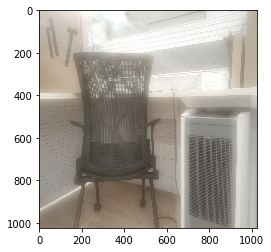

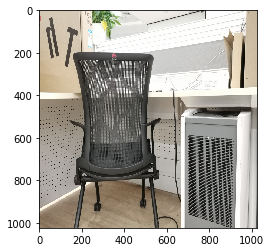

In [5]:
inp, re = load(PATH+'train/1.png')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [6]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [7]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [8]:
# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [9]:
@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

As you can see in the images below
that they are going through random jittering
Random jittering as described in the paper is to

1. Resize an image to bigger height and width
2. Randomly crop to the target size
3. Randomly flip the image horizontally

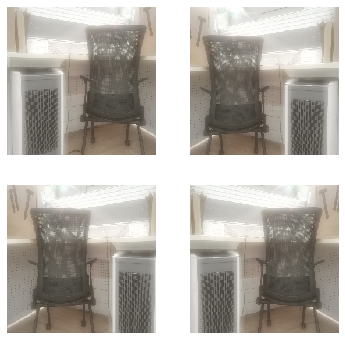

In [10]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [11]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [12]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

## Input Pipeline

In [13]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [14]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).



In [15]:
OUTPUT_CHANNELS = 3

In [16]:
def downsample(filters, size, apply_batchnorm=True, name='downsample'):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',name=name+'_conv',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [17]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 512, 512, 3)


In [18]:
def upsample(filters, size, apply_dropout=False, name='upsample'):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    name=name+'_transposeconv',
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [19]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 1024, 1024, 3)


In [20]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False,name='downsample_1'), # (bs, 128, 128, 64)
    downsample(128, 4,name='downsample_2'), # (bs, 64, 64, 128)
    downsample(256, 4,name='downsample_3'), # (bs, 32, 32, 256)
    downsample(512, 4,name='downsample_4'), # (bs, 16, 16, 512)
    downsample(512, 4,name='downsample_5'), # (bs, 8, 8, 512)
    downsample(512, 4,name='downsample_6'), # (bs, 4, 4, 512)
    downsample(512, 4,name='downsample_7'), # (bs, 2, 2, 512)
    downsample(512, 4,name='downsample_8'), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True,name='upsample_1'), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True,name='upsample_2'), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True,name='upsample_3'), # (bs, 8, 8, 1024)
    upsample(512, 4,name='upsample_4'), # (bs, 16, 16, 1024)
    upsample(256, 4,name='upsample_5'), # (bs, 32, 32, 512)
    upsample(128, 4,name='upsample_6'), # (bs, 64, 64, 256)
    upsample(64, 4,name='upsample_7'), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh',
                                         name='upsample_8') # (bs, 256, 256, 3)

  x = inputs
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    print(colored(x.name + ' shape :: {} '.format(x.shape),'yellow', attrs=['blink']))
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    print(colored(x.name + ' shape :: {} '.format(x.shape),'cyan', attrs=['blink']))
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  print(colored(x.name + ' shape :: {} '.format(x.shape),'cyan', attrs=['blink']))

  return tf.keras.Model(inputs=inputs, outputs=x)

In [21]:
generator = Generator()
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

sequential_2/Identity:0 shape :: (None, 128, 128, 64) 
sequential_3/Identity:0 shape :: (None, 64, 64, 128) 
sequential_4/Identity:0 shape :: (None, 32, 32, 256) 
sequential_5/Identity:0 shape :: (None, 16, 16, 512) 
sequential_6/Identity:0 shape :: (None, 8, 8, 512) 
sequential_7/Identity:0 shape :: (None, 4, 4, 512) 
sequential_8/Identity:0 shape :: (None, 2, 2, 512) 
sequential_9/Identity:0 shape :: (None, 1, 1, 512) 
sequential_10/Identity:0 shape :: (None, 2, 2, 512) 
sequential_11/Identity:0 shape :: (None, 4, 4, 512) 
sequential_12/Identity:0 shape :: (None, 8, 8, 512) 
sequential_13/Identity:0 shape :: (None, 16, 16, 512) 
sequential_14/Identity:0 shape :: (None, 32, 32, 256) 
sequential_15/Identity:0 shape :: (None, 64, 64, 128) 
sequential_16/Identity:0 shape :: (None, 128, 128, 64) 
upsample_8/Identity:0 shape :: (None, 256, 256, 3) 


In [22]:
print('='*50)
text = colored('Total Trainable parameters of Generator are :: {}'.format(generator.count_params()), 'red', attrs=['reverse','blink'])
print(text)
print('='*50)

Total Trainable parameters of Generator are :: 54425859


## Assign Weights to Generator Network

In [25]:
names = [
        'downsample_1',
        'downsample_2',
        'downsample_3',
        'downsample_4',
        'downsample_5',
        'downsample_6',
        'downsample_7',
        'downsample_8',
        'upsample_1',
        'upsample_2',
        'upsample_3',
        'upsample_4',
        'upsample_5',
        'upsample_6',
        'upsample_7',
        'upsample_8',
        ]

In [43]:
for name in names:
    for layer in generator.layers:
        if name in layer.name:
            #print(layer.name)
            weights = np.load('Weights/{}/{}_weights.npy'.format(name,name))
            biases = np.load('Weights/{}/{}_bias.npy'.format(name,name))
            layer.set_weights([weights,biases])
        elif 'sequential' in layer.name:
            for layer2 in layer.layers:
                if name in layer2.name:
                    #print(layer2.name)
                    if 'downsample' in name:
                        weights = np.load('Weights/{}/{}_conv.npy'.format(name,name))
                        layer2.set_weights(weights)
                    elif 'upsample' in name:
                        weights = np.load('Weights/{}/{}_transposeconv.npy'.format(name,name))
                        layer2.set_weights(weights)
                        
print(colored('Weights Assigned Successfully !','grey'))

Weights Assigned Successfully !


In [44]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

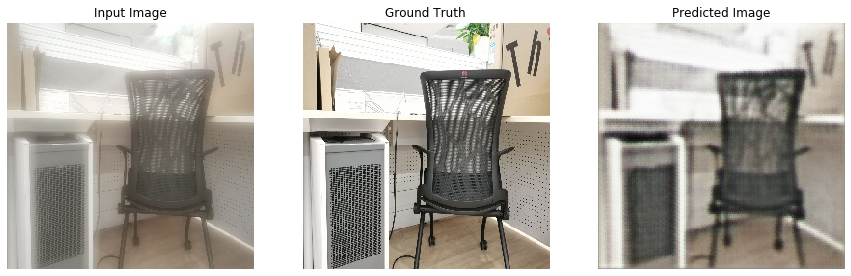

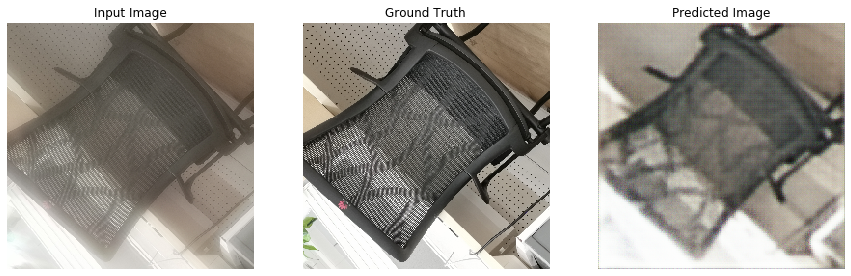

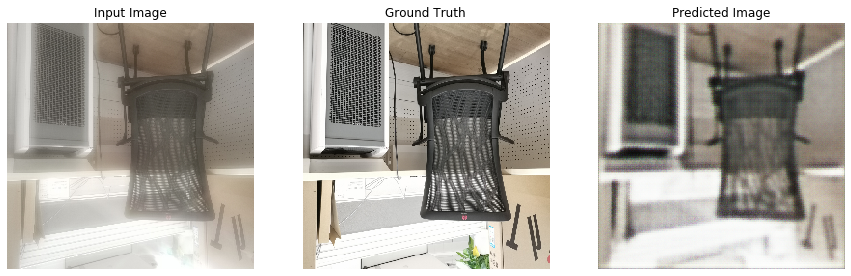

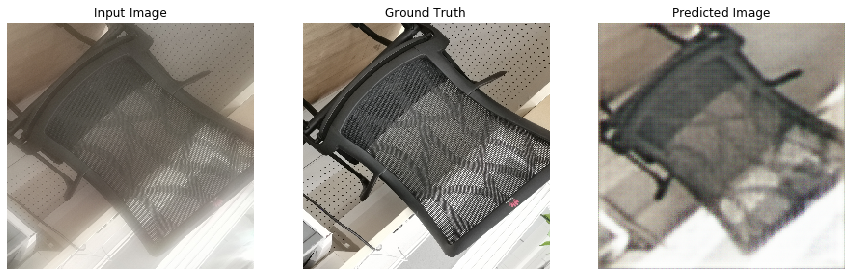

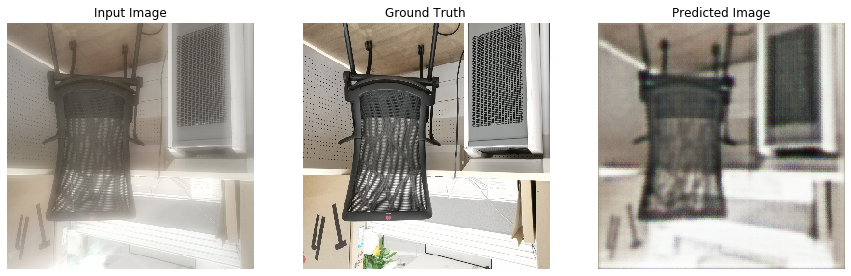

In [48]:
try:
    os.mkdir(experiment+'NEW_TEST/')
except:
    pass
num=1
for inp, tar in test_dataset.take(10):
    generate_images(generator, inp, tar)
    num+=1